MVAE model

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable


# Image Modality Encoder
class ImageVAEEncoder(nn.Module):
    def __init__(self, input_channels=1, latent_dim=256):
        super(ImageVAEEncoder, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.flatten = nn.Flatten()
        self.fc_mu = nn.Linear(in_features=64 * 28 * 28, out_features=latent_dim)
        self.fc_logvar = nn.Linear(in_features=64 * 28 * 28, out_features=latent_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.flatten(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar
    
    

# Image Modality Decoder
class ImageVAEDecoder(nn.Module):
    def __init__(self, latent_dim=256, output_channels=1):
        super(ImageVAEDecoder, self).__init__()
        self.fc = nn.Linear(in_features=latent_dim, out_features=64 * 28 * 28)
        self.convtrans1 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.convtrans2 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.convtrans3 = nn.ConvTranspose2d(16, output_channels, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.relu = nn.ReLU()
        self.output_activation = nn.Sigmoid()

    def forward(self, z):
        z = self.fc(z)
        z = z.view(-1, 64, 28, 28)
        z = self.relu(self.convtrans1(z))
        z = self.relu(self.convtrans2(z))
        z = self.output_activation(self.convtrans3(z))
        return z

# ECG Modality Encoder
class ECGVAEEncoder(nn.Module):
    def __init__(self, input_dim=60000, latent_dim=256):
        super(ECGVAEEncoder, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv1d(32, 64, kernel_size=3, stride=2, padding=1)
        self.flatten = nn.Flatten()
        self.fc_mu = nn.Linear(in_features=64 * (input_dim // 8), out_features=latent_dim)  # Adjusted for stride=2, 3 layers
        self.fc_logvar = nn.Linear(in_features=64 * (input_dim // 8), out_features=latent_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.flatten(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

# ECG Modality Decoder
class ECGVAEDecoder(nn.Module):
    def __init__(self, latent_dim=256, output_dim=60000):
        super(ECGVAEDecoder, self).__init__()
        self.fc = nn.Linear(in_features=latent_dim, out_features=64 * (output_dim // 8))
        self.convtrans1 = nn.ConvTranspose1d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.convtrans2 = nn.ConvTranspose1d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.convtrans3 = nn.ConvTranspose1d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.relu = nn.ReLU()
        self.output_activation = nn.Identity()  # Suitable for standardized data

    def forward(self, z):
        z = self.fc(z)
        z = z.view(-1, 64, z.size(1) // 64)  # Adjust the reshape for proper dimensions
        z = self.relu(self.convtrans1(z))
        z = self.relu(self.convtrans2(z))
        z = self.output_activation(self.convtrans3(z))
        return z

class CardioVAE(nn.Module):

    def __init__(self, image_input_channels=1, ecg_input_dim=60000, latent_dim=256):
        super(CardioVAE, self).__init__()
        self.image_encoder = ImageVAEEncoder(image_input_channels, latent_dim)
        self.ecg_encoder = ECGVAEEncoder(ecg_input_dim, latent_dim)
        self.image_decoder = ImageVAEDecoder(latent_dim, image_input_channels)
        self.ecg_decoder = ECGVAEDecoder(latent_dim, ecg_input_dim)

        self.experts       = ProductOfExperts()
        self.n_latents     = latent_dim

    def reparametrize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + eps * std
        else:
          return mu

    def forward(self, image=None, ecg=None):
        mu, logvar = self.infer(image, ecg)
        # reparametrization trick to sample
        z          = self.reparametrize(mu, logvar)
        # reconstruct inputs based on that gaussian
        img_recon  = self.image_decoder(z)
        ecg_recon  = self.ecg_decoder(z)
        return img_recon, ecg_recon, mu, logvar

    def infer(self, image=None, ecg=None): 
        batch_size = image.size(0) if image is not None else ecg.size(0)
        use_cuda   = next(self.parameters()).is_cuda  # check if CUDA
        # initialize the universal prior expert
        mu, logvar = prior_expert((1, batch_size, self.n_latents), 
                                  use_cuda=use_cuda)
        if image is not None:
            img_mu, img_logvar = self.image_encoder(image)
            mu     = torch.cat((mu, img_mu.unsqueeze(0)), dim=0)
            logvar = torch.cat((logvar, img_logvar.unsqueeze(0)), dim=0)

        if ecg is not None:
            ecg_mu, ecg_logvar = self.ecg_encoder(ecg)
            mu     = torch.cat((mu, ecg_mu.unsqueeze(0)), dim=0)
            logvar = torch.cat((logvar, ecg_logvar.unsqueeze(0)), dim=0)

        # product of experts to combine gaussians
        mu, logvar = self.experts(mu, logvar)
        return mu, logvar


class ProductOfExperts(nn.Module):
    """Return parameters for product of independent experts.
    See https://arxiv.org/pdf/1410.7827.pdf for equations.

    @param mu: M x D for M experts
    @param logvar: M x D for M experts
    """
    def forward(self, mu, logvar, eps=1e-8):
        var       = torch.exp(logvar) + eps
        # precision of i-th Gaussian expert at point x
        T         = 1. / (var + eps)
        pd_mu     = torch.sum(mu * T, dim=0) / torch.sum(T, dim=0)
        pd_var    = 1. / torch.sum(T, dim=0)
        pd_logvar = torch.log(pd_var + eps)
        return pd_mu, pd_logvar



def prior_expert(size, use_cuda=False):
    """Universal prior expert. Here we use a spherical
    Gaussian: N(0, 1).

    @param size: integer
                 dimensionality of Gaussian
    @param use_cuda: boolean [default: False]
                     cast CUDA on variables
    """
    mu     = Variable(torch.zeros(size))
    logvar = Variable(torch.zeros(size))
    if use_cuda:
        mu, logvar = mu.cuda(), logvar.cuda()
    return mu, logvar


MIMIC Dataloader

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as nnf

X_ecg_tensor = torch.load('data_feature/ecg_features_tensor.pt')
X_image_tensor = torch.load('data_feature/encoder_image_tensor.pt')


class ECGImageDataset(Dataset):
    def __init__(self, ecg_features, image_features):
        self.ecg_features = ecg_features
        self.image_features = image_features

    def __len__(self):
        return len(self.ecg_features)

    def __getitem__(self, idx):
        return self.ecg_features[idx], self.image_features[idx]
    
dataset = ECGImageDataset(X_ecg_tensor, X_image_tensor)

dataloader = DataLoader(dataset, batch_size=128, shuffle=True)  

Pre-Training

In [ ]:
import random 
import numpy as np
def set_seed(seed_value):
    """Set seed for reproducibility."""
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set a seed value
seed = 42
set_seed(seed)

# Device configuration
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


def elbo_loss(recon_xray, xray, recon_ecg, ecg, mu, logvar,
              lambda_xray=1.0, lambda_ecg=1.0, annealing_factor=1):

    xray_mse, ecg_mse = 0, 0
    if recon_xray is not None and xray is not None:
        # Reshape to the original image size
        xray_mse = nnf.mse_loss(recon_xray, xray, reduction='sum')

    if recon_ecg is not None and ecg is not None:
        # Reshape to the original image size
        ecg_mse = nnf.mse_loss(recon_ecg, ecg, reduction='sum')

    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
    
    ELBO = torch.mean(lambda_xray * xray_mse + lambda_ecg * ecg_mse + annealing_factor * KLD)
    
    return ELBO

# Utility Functions
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Training function
def train(epoch):
    model.train()
    train_loss_meter = AverageMeter()
    N_mini_batches = len(dataloader)

    for batch_idx, (ecg, xray) in enumerate(dataloader):
        annealing_factor = min(epoch / annealing_epochs, 1) if epoch < annealing_epochs else 1.0
        ecg, xray = ecg.to(device), xray.to(device)
    

        optimizer.zero_grad()
        recon_xray_joint, recon_ecg_joint, mu_joint, logvar_joint = model(xray, ecg)
        recon_xray_only, _, mu_xray, logvar_xray = model(image=xray)
        _, recon_ecg_only, mu_ecg, logvar_ecg = model(ecg=ecg)


        joint_loss = elbo_loss(recon_xray_joint, xray, recon_ecg_joint, ecg, mu_joint, logvar_joint, lambda_xray, lambda_ecg, annealing_factor)
        xray_loss = elbo_loss(recon_xray_only, xray, None, None, mu_xray, logvar_xray, lambda_xray, lambda_ecg, annealing_factor)
        ecg_loss = elbo_loss(None, None, recon_ecg_only, ecg, mu_ecg, logvar_ecg, lambda_xray, lambda_ecg, annealing_factor)


        train_loss = joint_loss + xray_loss + ecg_loss
        train_loss.backward()
        optimizer.step()

        train_loss_meter.update(train_loss.item(), len(ecg))
        if batch_idx % log_interval == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(ecg)}/{len(dataloader.dataset)} ({100. * batch_idx / N_mini_batches:.0f}%)]\tLoss: {train_loss_meter.avg:.6f}')

    return train_loss_meter.avg
   
# Hyperparameters
n_latents = 256
epochs = 100
annealing_epochs = 50
lr = 1e-3
log_interval = 10
lambda_xray = 1.0
lambda_ecg = 10.0 # 10

# Model and optimizer setup
model = CardioVAE(image_input_channels=1, ecg_input_dim=60000,latent_dim=n_latents).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

# Main training and validation loop
best_loss = float('inf')
for epoch in range(1, epochs + 1):
    train_loss = train(epoch)


# After training is complete
torch.save(model.state_dict(), 'pretrained_models/cardiovae.pth.pth')
print("Saved model state dictionary to 'cardiovae.pth'")

Fine-tuning on Aspire Dataset (ECG+Xray)

Dataloader

In [1]:
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from PIL import Image
import os
import pydicom
import torch
from torch.utils.data import Dataset
import numpy as np

class XRayDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []

        # Loop through each label directory
        for label in [0, 1]:
            label_dir = os.path.join(root_dir, f'processed_label_{label}')
            for folder_name in os.listdir(label_dir):
                folder_path = os.path.join(label_dir, folder_name)
                image_name = os.listdir(folder_path)[0]  # Assuming only one image per folder
                if image_name.endswith('.jpg'):
                    self.images.append(os.path.join(folder_path, image_name))
                    self.labels.append(label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = Image.open(image_path)
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label
    
 
# Initialize your dataset
xray_dataset = XRayDataset(root_dir='D:/Aspire_xray/xray', transform=transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.ToTensor(),
]))


def process_dicom(file_path, sampling_rate=500):
    desired_length = 10 * sampling_rate  # 10 seconds of data
    try:
        dicom_data = pydicom.dcmread(file_path)
        if "WaveformSequence" in dicom_data:
            rhythm_waveform = dicom_data.WaveformSequence[1]
            wave_data = rhythm_waveform.get("WaveformData")
            num_channels = rhythm_waveform.NumberOfWaveformChannels
            wave_array = np.frombuffer(wave_data, dtype=np.int16)
            num_samples_per_channel = wave_array.size // num_channels
            
            if wave_array.size % num_channels == 0:
                wave_array = wave_array.reshape(num_samples_per_channel, num_channels)
                

                # Trim or Pad the array to 10 seconds
                if wave_array.shape[0] > desired_length:
                    wave_array = wave_array[:desired_length, :]
                elif wave_array.shape[0] < desired_length:
                    padding = np.zeros((desired_length - wave_array.shape[0], num_channels), dtype=wave_array.dtype)
                    wave_array = np.vstack((wave_array, padding))
                
                # Normalize the array
                wave_array = (wave_array - np.mean(wave_array, axis=0)) / np.std(wave_array, axis=0)

                return wave_array
            else:
                print(f"Unexpected data size in {file_path}. Skipping file.")
                return None
        else:
            print(f"No Waveform data found in {file_path}. Skipping file.")
            return None
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return None


class ECGDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.ecg_data = []
        self.labels = []

        # Loop through each label directory
        for label in [0, 1]:
            label_dir = os.path.join(root_dir, f'processed_label_{label}')
            for folder_name in os.listdir(label_dir):
                folder_path = os.path.join(label_dir, folder_name)
                for file_name in os.listdir(folder_path):
                    if file_name.endswith('.dcm'):
                        file_path = os.path.join(folder_path, file_name)
                        ecg_waveform = process_dicom(file_path)
                        if ecg_waveform is not None:
                            self.ecg_data.append(ecg_waveform)
                            self.labels.append(label)

    def __len__(self):
        return len(self.ecg_data)

    def __getitem__(self, idx):
        ecg_waveform = self.ecg_data[idx]
        label = self.labels[idx]
        # Reshape waveform to [1, signal_length]
        ecg_waveform = ecg_waveform.reshape(1, -1)  
        return torch.tensor(ecg_waveform, dtype=torch.float32), label

# Usage example
ecg_dataset = ECGDataset(root_dir='D:/Aspire_ecg/ecg')

class CombinedDataset(Dataset):
    def __init__(self, xray_dataset, ecg_dataset):
        self.xray_dataset = xray_dataset
        self.ecg_dataset = ecg_dataset
        assert len(xray_dataset) == len(ecg_dataset), "Datasets must be of the same length."
        
        # Assuming the labels are the same for both datasets and can be directly accessed
        self.labels = [label for _, label in xray_dataset]

    def __len__(self):
        return len(self.xray_dataset)

    def __getitem__(self, idx):
        xray_image, xray_label = self.xray_dataset[idx]
        ecg_waveform, ecg_label = self.ecg_dataset[idx]
        
        # Ensure the labels match if they are supposed to be the same
        assert xray_label == ecg_label, "Labels do not match for the same index."
        
        return xray_image, ecg_waveform, xray_label  # Use either xray_label or ecg_label

    def get_labels(self):
        return self.labels

# Instantiate the combined dataset
combined_dataset = CombinedDataset(xray_dataset, ecg_dataset)
labels = combined_dataset.get_labels()

Model 

In [2]:

class MultimodalClassifier(nn.Module):
    def __init__(self, pretrained_mvae, num_classes):
        super(MultimodalClassifier, self).__init__()
        self.image_encoder = pretrained_mvae.image_encoder
        self.ecg_encoder = pretrained_mvae.ecg_encoder
        
        # Assuming you want to concatenate the encoded features
        combined_feature_dim = pretrained_mvae.n_latents * 2  # Since you're likely concatenating
        
        # Freeze the encoder weights
        for param in self.image_encoder.parameters():
            param.requires_grad = False
        for param in self.ecg_encoder.parameters():
            param.requires_grad = False

        self.classifier = nn.Sequential(
            nn.Linear(combined_feature_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes),
        )

    def forward(self, xray, ecg):
        mu_xray, _ = self.image_encoder(xray)
        mu_ecg, _ = self.ecg_encoder(ecg)
        combined_features = torch.cat((mu_xray, mu_ecg), dim=1)
        logits = self.classifier(combined_features)
        return logits

Training

In [3]:
from sklearn.metrics import accuracy_score, roc_auc_score

def train_classifier(model, train_loader, criterion, optimizer, epochs=50):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for xray, ecg, labels in train_loader:
            xray, ecg, labels = xray.to(device), ecg.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(xray, ecg)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item() * labels.size(0)
        
        avg_loss = total_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')

def evaluate_model(model, data_loader):
    model.eval()
    all_labels = []
    all_probs = []
    all_preds = []
    
    with torch.no_grad():
        for xray, ecg, labels in data_loader:
            xray, ecg, labels = xray.to(device), ecg.to(device), labels.to(device)
            logits = model(xray, ecg)
            probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1)
            
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    auc_score = roc_auc_score(all_labels, all_probs)
    accuracy = accuracy_score(all_labels, all_preds)
    
    return accuracy, auc_score

Latent Space 256 and ECG 10 and xray 1

In [4]:
import torch
import random
from sklearn.model_selection import StratifiedKFold
import numpy as np
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import accuracy_score, roc_auc_score


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def set_seed(seed_value):
    """Set seed for reproducibility."""
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
# Set a seed value
seed = 42
set_seed(seed)


skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
fold_results = []

for fold, (train_ids, test_ids) in enumerate(skf.split(np.zeros(len(labels)), labels)):
    
    train_subset = Subset(combined_dataset, train_ids)
    test_subset = Subset(combined_dataset, test_ids)
    
    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)
    
    # Load the pre-trained Multimodal VAE
    pretrained_mvae = CardioVAE(image_input_channels=1, ecg_input_dim=60000, latent_dim=256)
    pretrained_mvae.load_state_dict(torch.load('pretrained_models/cardiovae.pth', map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu')))
    pretrained_mvae.to(device)
    
    # Initialize the classifier for this fold
    model = MultimodalClassifier(pretrained_mvae=pretrained_mvae, num_classes=2).to(device)
    
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
    criterion = nn.CrossEntropyLoss()
    
    # Train the model
    train_classifier(model, train_loader, criterion, optimizer, epochs=50)
    
    # Evaluate the model on the test set
    accuracy, auc_score = evaluate_model(model, test_loader)
    fold_results.append((accuracy, auc_score))

    
# Calculate and print the mean and STD for each metric across folds
accuracies, aucs = zip(*fold_results)
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)

print(f'Mean Accuracy: {mean_accuracy:.3f}, STD: {std_accuracy:.3f}')
print(f'Mean AUC: {mean_auc:.3f}, STD: {std_auc:.3f}')

Mean Accuracy: 0.772, STD: 0.04
Mean AUC: 0.790, STD: 0.03


In [333]:
# Save the model
torch.save(model.state_dict(), 'multimodal_classifier.pth')

In [8]:
# Initialize the model
pretrained_mvae = CardioVAE(image_input_channels=1, ecg_input_dim=60000, latent_dim=256)
pretrained_mvae.load_state_dict(torch.load('pretrained_models/mvae_test.pth', map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu')))
pretrained_mvae.to(device)

model = MultimodalClassifier(pretrained_mvae=pretrained_mvae, num_classes=2).to(device)

# Load the saved model state dictionary
model.load_state_dict(torch.load('multimodal_classifier.pth', map_location=device))


<All keys matched successfully>

Feature Interpretation

Actual Label: 1
Predicted Label: 1


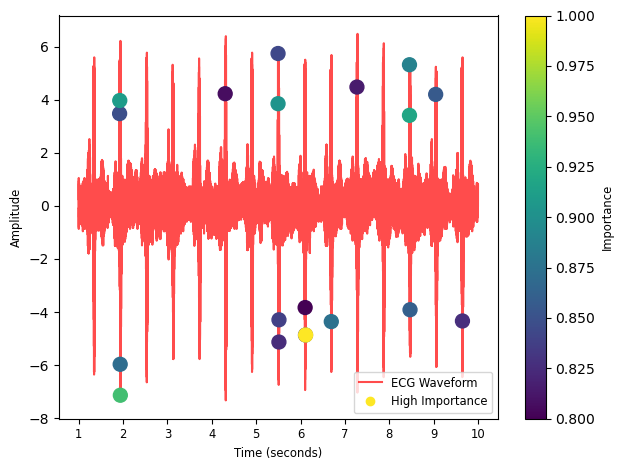

In [260]:
from captum.attr import IntegratedGradients
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LinearSegmentedColormap
import numpy as np  # Ensure NumPy is imported

# Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get a sample from the combined dataset
xray_image, ecg_waveform, label = combined_dataset[712]

# Move the input tensors to the device
xray_image = xray_image.unsqueeze(0).to(device)
ecg_waveform = ecg_waveform.unsqueeze(0).to(device)

# Preprocess and forward the sample through the MultimodalClassifier
model.eval()  # Set the model to evaluation mode

# Assuming the model and data are on the same device, if not, move them to the same device (e.g., model.to(device))
with torch.no_grad():
    logits = model(xray_image, ecg_waveform)

# Get the predicted label
_, predicted_label = torch.max(logits, 1)

# Print actual and predicted labels
actual_label = label  # Assuming `label` is a tensor. Adjust if your actual label format is different.
predicted_label = predicted_label.item()  # Convert tensor to integer for easier comparison/printing

print(f"Actual Label: {actual_label}")
print(f"Predicted Label: {predicted_label}")

# Initialize Integrated Gradients for the model
integrated_gradients = IntegratedGradients(model)

# Compute attributions for both X-ray and ECG inputs
# Note: We need to enable gradients by setting requires_grad to True for both inputs
xray_image.requires_grad_(True)
ecg_waveform.requires_grad_(True)

# Calculate attributions for X-ray and ECG together
attributions, _ = integrated_gradients.attribute(inputs=(xray_image, ecg_waveform),
                                                 target=predicted_label,
                                                 return_convergence_delta=True)

# Separate the attributions for the X-ray and ECG
attributions_xray = attributions[0]
attributions_ecg = attributions[1]

# Convert ECG attributions to numpy for visualization
attributions_ecg_np = attributions_ecg.cpu().detach().numpy().squeeze()

# Normalize the ECG attributions to get importance scores between 0 and 1 for the colormap
norm_attributions_ecg = (attributions_ecg_np - attributions_ecg_np.min()) / (attributions_ecg_np.max() - attributions_ecg_np.min())

# Visualize important regions for ECG
# (X-ray visualization would require a separate approach, not covered here)
threshold = 0.80
important_indices_ecg = np.where(norm_attributions_ecg >= threshold)
ecg_waveform_np = ecg_waveform.cpu().detach().numpy().squeeze()


num_points = len(ecg_waveform_np)

fig, ax = plt.subplots()

# Set the background color of the plot to white
fig.patch.set_facecolor('white')
ax.set_facecolor('white')


# If your data has a specific range or scale, adjust these values to match the actual scale
ax.set_xticks(np.linspace(0, num_points, 10))  # This creates 10 evenly spaced ticks across the data

# Set the x-axis tick labels to range from 1 to 10
ax.set_xticklabels(np.arange(1, 11), size='small')  # Labels from 1 to 10


# Plot the ECG waveform in dark black
ax.plot(ecg_waveform_np, label='ECG Waveform', color='red', alpha=0.7)


# Choose the colormap for the importance scores
chosen_cmap = 'viridis'  # You can choose from 'viridis', 'plasma', 'inferno', 'magma', 'cividis'

# Overlay important attributions for ECG with larger points using the chosen colormap
ax.scatter(important_indices_ecg, ecg_waveform_np[important_indices_ecg], s=100, 
           c=norm_attributions_ecg[important_indices_ecg], cmap=chosen_cmap, zorder=3)

# Create a colorbar for ECG using the chosen colormap
sm = ScalarMappable(cmap=chosen_cmap, norm=Normalize(vmin=threshold, vmax=1))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Importance', size='small')  # Reduce the font size of the color bar label

# Get the highest importance color (which corresponds to 1 in the colormap)
highest_importance_color = plt.get_cmap(chosen_cmap)(1.0)

# Set the 'High Importance' label color to match the highest importance color from the chosen colormap
for label, color in zip(['High Importance'], [highest_importance_color,]):
    ax.plot([], [], label=label, color=color, linestyle='None', marker='o', markerfacecolor=color)
ax.legend(loc='best', fontsize='small')  # Reduce the font size of the legend

# Enhance the plot for ECG
ax.set_xlabel('Time (seconds)', size='small')  # Reduce the font size of the x-label
ax.set_ylabel('Amplitude', size='small')  # Reduce the font size of the y-label
#ax.set_title('ECG Waveform with High Importance Regions Highlighted', size='medium')  # Reduce the font size of the title

plt.tight_layout()
plt.show()

Actual Label: 0
Predicted Label: 0


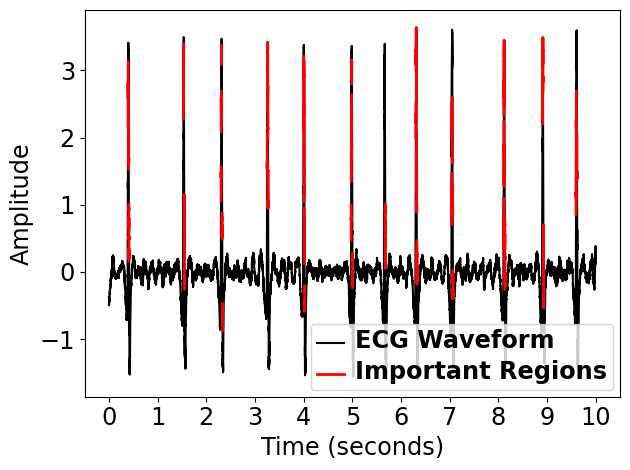

In [597]:
from captum.attr import IntegratedGradients
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LinearSegmentedColormap
import numpy as np  # Ensure NumPy is imported

# Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get a sample from the combined dataset
xray_image, ecg_waveform, label = combined_dataset[13]

# Move the input tensors to the device
xray_image = xray_image.unsqueeze(0).to(device)
ecg_waveform_1 = ecg_waveform
ecg_waveform = ecg_waveform.unsqueeze(0).to(device)


# Preprocess and forward the sample through the MultimodalClassifier
model.eval()  # Set the model to evaluation mode

# Assuming the model and data are on the same device, if not, move them to the same device (e.g., model.to(device))
with torch.no_grad():
    logits = model(xray_image, ecg_waveform)

# Get the predicted label
_, predicted_label = torch.max(logits, 1)

# Print actual and predicted labels
actual_label = label  # Assuming `label` is a tensor. Adjust if your actual label format is different.
predicted_label = predicted_label.item()  # Convert tensor to integer for easier comparison/printing

print(f"Actual Label: {actual_label}")
print(f"Predicted Label: {predicted_label}")


# Step 1: Smooth the ECG signal
# Convert the 2D ECG signal array into a 1D array
ecg_waveform_1d = np.ravel(ecg_waveform_1)

# Now, use the `ecg_clean` function with the 1D array
ecg_smoothed = nk.ecg_clean(ecg_waveform_1d, sampling_rate=500)  # Adjust the sampling rate as per your data

# Initialize Integrated Gradients for the model
integrated_gradients = IntegratedGradients(model)

# Compute attributions for both X-ray and ECG inputs
# Note: We need to enable gradients by setting requires_grad to True for both inputs
# Convert ECG smoothed signal back to PyTorch tensor and then move it to the specified device
ecg_smoothed = torch.tensor(ecg_smoothed.copy(), dtype=torch.float32).to(device)


xray_image.requires_grad_(True)
ecg_smoothed.requires_grad_(True)

# Calculate attributions for X-ray and ECG together
attributions, _ = integrated_gradients.attribute(inputs=(xray_image, ecg_waveform),
                                                 target=predicted_label,
                                                 return_convergence_delta=True)

# Separate the attributions for the X-ray and ECG
attributions_xray = attributions[0]
attributions_ecg = attributions[1]

# Convert ECG attributions to numpy for visualization
attributions_ecg_np = attributions_ecg.cpu().detach().numpy().squeeze()

# Normalize the ECG attributions to get importance scores between 0 and 1 for the colormap
norm_attributions_ecg = (attributions_ecg_np - attributions_ecg_np.min()) / (attributions_ecg_np.max() - attributions_ecg_np.min())

# Visualize important regions for ECG
# (X-ray visualization would require a separate approach, not covered here)
threshold = 0.80
important_indices_ecg = np.where(norm_attributions_ecg >= threshold)
ecg_waveform_np = ecg_smoothed.cpu().detach().numpy().squeeze()

# Assuming attributions_np and ecg_waveform_np are already calculated

# Define the segment range you are interested in
start_index = 0
end_index = 60000

# Extract the segment of interest from the ECG waveform and attributions
segment_ecg_waveform = ecg_waveform_np[start_index:end_index]
segment_attributions = norm_attributions_ecg[start_index:end_index]

# For plotting, we will also need the indices relative to the segment
segment_indices = np.arange(start_index, end_index)
# Define the threshold to identify important points
threshold = 0.70  # Adjust the threshold as necessary

# Calculate the important indices based on the threshold within the segment
important_indices_segment = np.where(segment_attributions >= threshold)[0]

# Convert logits to probabilities
probabilities = torch.softmax(logits, dim=1)
predicted_probability = probabilities[0, predicted_label].item()  # Get the probability of the predicted class



sampling_rate = 500
# Assuming the segment_indices cover a range that corresponds to 10 seconds at a sampling rate of 500 samples/second
# Generate x-axis labels from 0 to 10 seconds
time_in_seconds = segment_indices / sampling_rate  # Convert indices to time in seconds
adjusted_time_in_seconds = np.linspace(0, 10, len(segment_indices))  # Adjust for the plot

fig, ax = plt.subplots()

# Set the background color of the plot to white
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Plot the entire segment of the ECG waveform in black
ax.plot(adjusted_time_in_seconds, segment_ecg_waveform, label='ECG Waveform', color='black', alpha=1)
stretch_window = 6
# Highlight important regions in red
for important_index in important_indices_segment:
    # Calculate start and end of the important region considering the window around the important index
    stretch_start = max(0, important_index - stretch_window)
    stretch_end = min(len(segment_ecg_waveform), important_index + stretch_window + 1)
    # Adjust time for the important segments
    important_segment_time = adjusted_time_in_seconds[stretch_start:stretch_end]
    ax.plot(important_segment_time, segment_ecg_waveform[stretch_start:stretch_end], color='red', linewidth=2, zorder=3)

# Adjust the x-axis to only show labels from 0 to 10 seconds
ax.set_xlabel('Time (seconds)', fontsize='xx-large')  # Increase x-label font size
ax.set_xticks(np.linspace(0, 10, 11))  # Show ticks from 0 to 10 seconds
ax.set_ylabel('Amplitude', fontsize='xx-large')  # Increase y-label font size

# Increase the size of the x and y ticks
ax.tick_params(axis='x', labelsize='xx-large')  # Increase x-tick font size
ax.tick_params(axis='y', labelsize='xx-large')  # Increase y-tick font size

# Add legend with large font size and make it bold
legend = ax.legend(['ECG Waveform', 'Important Regions'], loc='lower right', fontsize='medium')
for text in legend.get_texts():
    text.set_fontsize('xx-large')  # for larger text
    text.set_fontweight('bold')  # for bold text

plt.tight_layout()
plt.show()






Actual Label: 0
Predicted Label: 0


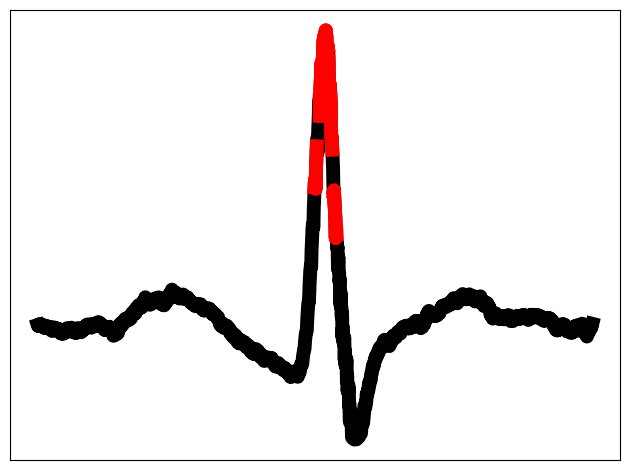

In [594]:
from captum.attr import IntegratedGradients
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LinearSegmentedColormap
import numpy as np  # Ensure NumPy is imported

# Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get a sample from the combined dataset
xray_image, ecg_waveform, label = combined_dataset[13]

# Move the input tensors to the device
xray_image = xray_image.unsqueeze(0).to(device)
ecg_waveform_1 = ecg_waveform
ecg_waveform = ecg_waveform.unsqueeze(0).to(device)


# Preprocess and forward the sample through the MultimodalClassifier
model.eval()  # Set the model to evaluation mode

# Assuming the model and data are on the same device, if not, move them to the same device (e.g., model.to(device))
with torch.no_grad():
    logits = model(xray_image, ecg_waveform)

# Get the predicted label
_, predicted_label = torch.max(logits, 1)

# Print actual and predicted labels
actual_label = label  # Assuming `label` is a tensor. Adjust if your actual label format is different.
predicted_label = predicted_label.item()  # Convert tensor to integer for easier comparison/printing

print(f"Actual Label: {actual_label}")
print(f"Predicted Label: {predicted_label}")


# Step 1: Smooth the ECG signal
# Convert the 2D ECG signal array into a 1D array
ecg_waveform_1d = np.ravel(ecg_waveform_1)

# Now, use the `ecg_clean` function with the 1D array
ecg_smoothed = nk.ecg_clean(ecg_waveform_1d, sampling_rate=500)  # Adjust the sampling rate as per your data

# Initialize Integrated Gradients for the model
integrated_gradients = IntegratedGradients(model)

# Compute attributions for both X-ray and ECG inputs
# Note: We need to enable gradients by setting requires_grad to True for both inputs
# Convert ECG smoothed signal back to PyTorch tensor and then move it to the specified device
ecg_smoothed = torch.tensor(ecg_smoothed.copy(), dtype=torch.float32).to(device)


xray_image.requires_grad_(True)
ecg_smoothed.requires_grad_(True)

# Calculate attributions for X-ray and ECG together
attributions, _ = integrated_gradients.attribute(inputs=(xray_image, ecg_waveform),
                                                 target=predicted_label,
                                                 return_convergence_delta=True)

# Separate the attributions for the X-ray and ECG
attributions_xray = attributions[0]
attributions_ecg = attributions[1]

# Convert ECG attributions to numpy for visualization
attributions_ecg_np = attributions_ecg.cpu().detach().numpy().squeeze()

# Normalize the ECG attributions to get importance scores between 0 and 1 for the colormap
norm_attributions_ecg = (attributions_ecg_np - attributions_ecg_np.min()) / (attributions_ecg_np.max() - attributions_ecg_np.min())

# Visualize important regions for ECG
# (X-ray visualization would require a separate approach, not covered here)
threshold = 0.80
important_indices_ecg = np.where(norm_attributions_ecg >= threshold)
ecg_waveform_np = ecg_smoothed.cpu().detach().numpy().squeeze()

# Assuming attributions_np and ecg_waveform_np are already calculated

# Define the segment range you are interested in
start_index = 18000
end_index = 21000

# Extract the segment of interest from the ECG waveform and attributions
segment_ecg_waveform = ecg_waveform_np[start_index:end_index]
segment_attributions = norm_attributions_ecg[start_index:end_index]

# For plotting, we will also need the indices relative to the segment
segment_indices = np.arange(start_index, end_index)


# Define the threshold to identify important points
threshold = 0.70  # Adjust the threshold as necessary

# Calculate the important indices based on the threshold within the segment
important_indices_segment = np.where(segment_attributions >= threshold)[0]

# Convert logits to probabilities
probabilities = torch.softmax(logits, dim=1)
predicted_probability = probabilities[0, predicted_label].item()  # Get the probability of the predicted class



fig, ax = plt.subplots()

# Set the background color of the plot to white
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Increase linewidth for better visualization
waveform_linewidth = 10 # Adjust the ECG waveform line thickness
important_linewidth = 10  # Adjust the important regions line thickness

# Plot the entire segment of the ECG waveform in a base color (e.g., green) with increased linewidth
ax.plot(segment_indices, segment_ecg_waveform, label='ECG Waveform', color='black', alpha=1, linewidth=waveform_linewidth)
stretch_window = 6

# Plot the stretched important segment in red with increased linewidth
for important_index in important_indices_segment:
    stretch_start = max(0, important_index - stretch_window)
    stretch_end = min(len(segment_ecg_waveform), important_index + stretch_window + 1)
    ax.plot(segment_indices[stretch_start:stretch_end], 
            segment_ecg_waveform[stretch_start:stretch_end], 
            color='red', linewidth=important_linewidth, zorder=3)

# Remove x-ticks and y-ticks
ax.set_xticks([])  # Remove x-ticks
ax.set_yticks([])  # Remove y-ticks

ax.set_xlabel('')
ax.set_ylabel('')

plt.tight_layout()
plt.show()



Actual Label: 0
Predicted Label: 0


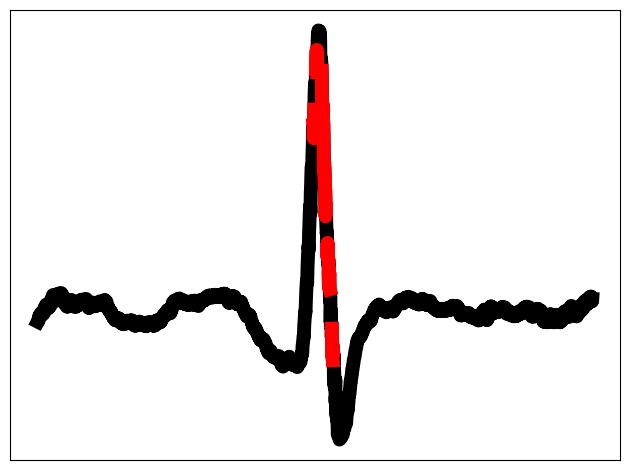

In [595]:
from captum.attr import IntegratedGradients
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LinearSegmentedColormap
import numpy as np  # Ensure NumPy is imported

# Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get a sample from the combined dataset
xray_image, ecg_waveform, label = combined_dataset[13]

# Move the input tensors to the device
xray_image = xray_image.unsqueeze(0).to(device)
ecg_waveform_1 = ecg_waveform
ecg_waveform = ecg_waveform.unsqueeze(0).to(device)


# Preprocess and forward the sample through the MultimodalClassifier
model.eval()  # Set the model to evaluation mode

# Assuming the model and data are on the same device, if not, move them to the same device (e.g., model.to(device))
with torch.no_grad():
    logits = model(xray_image, ecg_waveform)

# Get the predicted label
_, predicted_label = torch.max(logits, 1)

# Print actual and predicted labels
actual_label = label  # Assuming `label` is a tensor. Adjust if your actual label format is different.
predicted_label = predicted_label.item()  # Convert tensor to integer for easier comparison/printing

print(f"Actual Label: {actual_label}")
print(f"Predicted Label: {predicted_label}")


# Step 1: Smooth the ECG signal
# Convert the 2D ECG signal array into a 1D array
ecg_waveform_1d = np.ravel(ecg_waveform_1)

# Now, use the `ecg_clean` function with the 1D array
ecg_smoothed = nk.ecg_clean(ecg_waveform_1d, sampling_rate=500)  # Adjust the sampling rate as per your data

# Initialize Integrated Gradients for the model
integrated_gradients = IntegratedGradients(model)

# Compute attributions for both X-ray and ECG inputs
# Note: We need to enable gradients by setting requires_grad to True for both inputs
# Convert ECG smoothed signal back to PyTorch tensor and then move it to the specified device
ecg_smoothed = torch.tensor(ecg_smoothed.copy(), dtype=torch.float32).to(device)


xray_image.requires_grad_(True)
ecg_smoothed.requires_grad_(True)

# Calculate attributions for X-ray and ECG together
attributions, _ = integrated_gradients.attribute(inputs=(xray_image, ecg_waveform),
                                                 target=predicted_label,
                                                 return_convergence_delta=True)

# Separate the attributions for the X-ray and ECG
attributions_xray = attributions[0]
attributions_ecg = attributions[1]

# Convert ECG attributions to numpy for visualization
attributions_ecg_np = attributions_ecg.cpu().detach().numpy().squeeze()

# Normalize the ECG attributions to get importance scores between 0 and 1 for the colormap
norm_attributions_ecg = (attributions_ecg_np - attributions_ecg_np.min()) / (attributions_ecg_np.max() - attributions_ecg_np.min())

# Visualize important regions for ECG
# (X-ray visualization would require a separate approach, not covered here)
threshold = 0.80
important_indices_ecg = np.where(norm_attributions_ecg >= threshold)
ecg_waveform_np = ecg_smoothed.cpu().detach().numpy().squeeze()

# Assuming attributions_np and ecg_waveform_np are already calculated

# Define the segment range you are interested in
start_index = 22000
end_index = 26000

# Extract the segment of interest from the ECG waveform and attributions
segment_ecg_waveform = ecg_waveform_np[start_index:end_index]
segment_attributions = norm_attributions_ecg[start_index:end_index]

# For plotting, we will also need the indices relative to the segment
segment_indices = np.arange(start_index, end_index)


# Define the threshold to identify important points
threshold = 0.70  # Adjust the threshold as necessary

# Calculate the important indices based on the threshold within the segment
important_indices_segment = np.where(segment_attributions >= threshold)[0]

# Convert logits to probabilities
probabilities = torch.softmax(logits, dim=1)
predicted_probability = probabilities[0, predicted_label].item()  # Get the probability of the predicted class



fig, ax = plt.subplots()

# Set the background color of the plot to white
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Increase linewidth for better visualization
waveform_linewidth = 10  # Adjust the ECG waveform line thickness
important_linewidth = 10 # Adjust the important regions line thickness

# Plot the entire segment of the ECG waveform in a base color (e.g., green) with increased linewidth
ax.plot(segment_indices, segment_ecg_waveform, label='ECG Waveform', color='black', alpha=1, linewidth=waveform_linewidth)
stretch_window = 3

# Plot the stretched important segment in red with increased linewidth
for important_index in important_indices_segment:
    stretch_start = max(0, important_index - stretch_window)
    stretch_end = min(len(segment_ecg_waveform), important_index + stretch_window + 1)
    ax.plot(segment_indices[stretch_start:stretch_end], 
            segment_ecg_waveform[stretch_start:stretch_end], 
            color='red', linewidth=important_linewidth, zorder=3)

# Remove x-ticks and y-ticks
ax.set_xticks([])  # Remove x-ticks
ax.set_yticks([])  # Remove y-ticks

ax.set_xlabel('')
ax.set_ylabel('')

plt.tight_layout()
plt.show()



Actual Label: 1
Predicted Label: 1


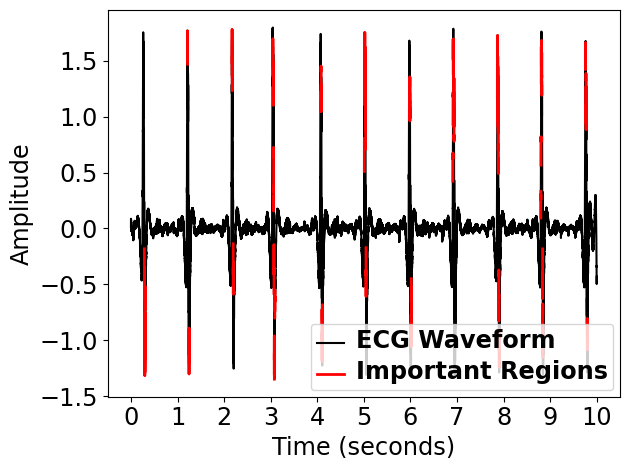

In [599]:
from captum.attr import IntegratedGradients
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LinearSegmentedColormap
import numpy as np  # Ensure NumPy is imported

# Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get a sample from the combined dataset
xray_image, ecg_waveform, label = combined_dataset[662]

# Move the input tensors to the device
xray_image = xray_image.unsqueeze(0).to(device)
ecg_waveform_1 = ecg_waveform
ecg_waveform = ecg_waveform.unsqueeze(0).to(device)


# Preprocess and forward the sample through the MultimodalClassifier
model.eval()  # Set the model to evaluation mode

# Assuming the model and data are on the same device, if not, move them to the same device (e.g., model.to(device))
with torch.no_grad():
    logits = model(xray_image, ecg_waveform)

# Get the predicted label
_, predicted_label = torch.max(logits, 1)

# Print actual and predicted labels
actual_label = label  # Assuming `label` is a tensor. Adjust if your actual label format is different.
predicted_label = predicted_label.item()  # Convert tensor to integer for easier comparison/printing

print(f"Actual Label: {actual_label}")
print(f"Predicted Label: {predicted_label}")


# Step 1: Smooth the ECG signal
# Convert the 2D ECG signal array into a 1D array
ecg_waveform_1d = np.ravel(ecg_waveform_1)

# Now, use the `ecg_clean` function with the 1D array
ecg_smoothed = nk.ecg_clean(ecg_waveform_1d, sampling_rate=500)  # Adjust the sampling rate as per your data

# Initialize Integrated Gradients for the model
integrated_gradients = IntegratedGradients(model)

# Compute attributions for both X-ray and ECG inputs
# Note: We need to enable gradients by setting requires_grad to True for both inputs
# Convert ECG smoothed signal back to PyTorch tensor and then move it to the specified device
ecg_smoothed = torch.tensor(ecg_smoothed.copy(), dtype=torch.float32).to(device)


xray_image.requires_grad_(True)
ecg_smoothed.requires_grad_(True)

# Calculate attributions for X-ray and ECG together
attributions, _ = integrated_gradients.attribute(inputs=(xray_image, ecg_waveform),
                                                 target=predicted_label,
                                                 return_convergence_delta=True)

# Separate the attributions for the X-ray and ECG
attributions_xray = attributions[0]
attributions_ecg = attributions[1]

# Convert ECG attributions to numpy for visualization
attributions_ecg_np = attributions_ecg.cpu().detach().numpy().squeeze()

# Normalize the ECG attributions to get importance scores between 0 and 1 for the colormap
norm_attributions_ecg = (attributions_ecg_np - attributions_ecg_np.min()) / (attributions_ecg_np.max() - attributions_ecg_np.min())

# Visualize important regions for ECG
# (X-ray visualization would require a separate approach, not covered here)
threshold = 0.80
important_indices_ecg = np.where(norm_attributions_ecg >= threshold)
ecg_waveform_np = ecg_smoothed.cpu().detach().numpy().squeeze()

# Assuming attributions_np and ecg_waveform_np are already calculated

# Define the segment range you are interested in
start_index = 0
end_index = 60000

# Extract the segment of interest from the ECG waveform and attributions
segment_ecg_waveform = ecg_waveform_np[start_index:end_index]
segment_attributions = norm_attributions_ecg[start_index:end_index]

# For plotting, we will also need the indices relative to the segment
segment_indices = np.arange(start_index, end_index)
# Define the threshold to identify important points
threshold = 0.70  # Adjust the threshold as necessary

# Calculate the important indices based on the threshold within the segment
important_indices_segment = np.where(segment_attributions >= threshold)[0]

# Convert logits to probabilities
probabilities = torch.softmax(logits, dim=1)
predicted_probability = probabilities[0, predicted_label].item()  # Get the probability of the predicted class



sampling_rate = 500
# Assuming the segment_indices cover a range that corresponds to 10 seconds at a sampling rate of 500 samples/second
# Generate x-axis labels from 0 to 10 seconds
time_in_seconds = segment_indices / sampling_rate  # Convert indices to time in seconds
adjusted_time_in_seconds = np.linspace(0, 10, len(segment_indices))  # Adjust for the plot

fig, ax = plt.subplots()

# Set the background color of the plot to white
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Plot the entire segment of the ECG waveform in black
ax.plot(adjusted_time_in_seconds, segment_ecg_waveform, label='ECG Waveform', color='black', alpha=1)
stretch_window = 6
# Highlight important regions in red
for important_index in important_indices_segment:
    # Calculate start and end of the important region considering the window around the important index
    stretch_start = max(0, important_index - stretch_window)
    stretch_end = min(len(segment_ecg_waveform), important_index + stretch_window + 1)
    # Adjust time for the important segments
    important_segment_time = adjusted_time_in_seconds[stretch_start:stretch_end]
    ax.plot(important_segment_time, segment_ecg_waveform[stretch_start:stretch_end], color='red', linewidth=2, zorder=3)

# Adjust the x-axis to only show labels from 0 to 10 seconds
ax.set_xlabel('Time (seconds)', fontsize='xx-large')  # Increase x-label font size
ax.set_xticks(np.linspace(0, 10, 11))  # Show ticks from 0 to 10 seconds
ax.set_ylabel('Amplitude', fontsize='xx-large')  # Increase y-label font size

# Increase the size of the x and y ticks
ax.tick_params(axis='x', labelsize='xx-large')  # Increase x-tick font size
ax.tick_params(axis='y', labelsize='xx-large')  # Increase y-tick font size

# Add legend with large font size and make it bold
legend = ax.legend(['ECG Waveform', 'Important Regions'], loc='lower right', fontsize='medium')
for text in legend.get_texts():
    text.set_fontsize('xx-large')  # for larger text
    text.set_fontweight('bold')  # for bold text

plt.tight_layout()
plt.show()




Actual Label: 1
Predicted Label: 1


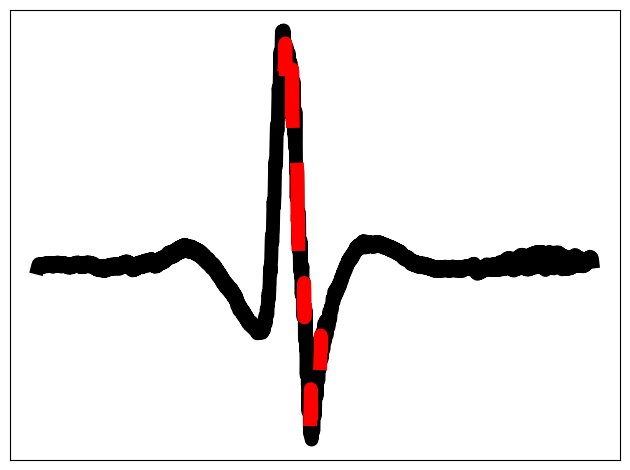

In [601]:
from captum.attr import IntegratedGradients
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LinearSegmentedColormap
import numpy as np  # Ensure NumPy is imported

# Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get a sample from the combined dataset
xray_image, ecg_waveform, label = combined_dataset[662]

# Move the input tensors to the device
xray_image = xray_image.unsqueeze(0).to(device)
ecg_waveform_1 = ecg_waveform
ecg_waveform = ecg_waveform.unsqueeze(0).to(device)


# Preprocess and forward the sample through the MultimodalClassifier
model.eval()  # Set the model to evaluation mode

# Assuming the model and data are on the same device, if not, move them to the same device (e.g., model.to(device))
with torch.no_grad():
    logits = model(xray_image, ecg_waveform)

# Get the predicted label
_, predicted_label = torch.max(logits, 1)

# Print actual and predicted labels
actual_label = label  # Assuming `label` is a tensor. Adjust if your actual label format is different.
predicted_label = predicted_label.item()  # Convert tensor to integer for easier comparison/printing

print(f"Actual Label: {actual_label}")
print(f"Predicted Label: {predicted_label}")


# Step 1: Smooth the ECG signal
# Convert the 2D ECG signal array into a 1D array
ecg_waveform_1d = np.ravel(ecg_waveform_1)

# Now, use the `ecg_clean` function with the 1D array
ecg_smoothed = nk.ecg_clean(ecg_waveform_1d, sampling_rate=500)  # Adjust the sampling rate as per your data

# Initialize Integrated Gradients for the model
integrated_gradients = IntegratedGradients(model)

# Compute attributions for both X-ray and ECG inputs
# Note: We need to enable gradients by setting requires_grad to True for both inputs
# Convert ECG smoothed signal back to PyTorch tensor and then move it to the specified device
ecg_smoothed = torch.tensor(ecg_smoothed.copy(), dtype=torch.float32).to(device)


xray_image.requires_grad_(True)
ecg_smoothed.requires_grad_(True)

# Calculate attributions for X-ray and ECG together
attributions, _ = integrated_gradients.attribute(inputs=(xray_image, ecg_waveform),
                                                 target=predicted_label,
                                                 return_convergence_delta=True)

# Separate the attributions for the X-ray and ECG
attributions_xray = attributions[0]
attributions_ecg = attributions[1]

# Convert ECG attributions to numpy for visualization
attributions_ecg_np = attributions_ecg.cpu().detach().numpy().squeeze()

# Normalize the ECG attributions to get importance scores between 0 and 1 for the colormap
norm_attributions_ecg = (attributions_ecg_np - attributions_ecg_np.min()) / (attributions_ecg_np.max() - attributions_ecg_np.min())

# Visualize important regions for ECG
# (X-ray visualization would require a separate approach, not covered here)
threshold = 0.80
important_indices_ecg = np.where(norm_attributions_ecg >= threshold)
ecg_waveform_np = ecg_smoothed.cpu().detach().numpy().squeeze()

# Assuming attributions_np and ecg_waveform_np are already calculated

# Define the segment range you are interested in
start_index = 16500
end_index = 20500

# Extract the segment of interest from the ECG waveform and attributions
segment_ecg_waveform = ecg_waveform_np[start_index:end_index]
segment_attributions = norm_attributions_ecg[start_index:end_index]

# For plotting, we will also need the indices relative to the segment
segment_indices = np.arange(start_index, end_index)


# Define the threshold to identify important points
threshold = 0.70  # Adjust the threshold as necessary

# Calculate the important indices based on the threshold within the segment
important_indices_segment = np.where(segment_attributions >= threshold)[0]

# Convert logits to probabilities
probabilities = torch.softmax(logits, dim=1)
predicted_probability = probabilities[0, predicted_label].item()  # Get the probability of the predicted class



fig, ax = plt.subplots()

# Set the background color of the plot to white
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Increase linewidth for better visualization
waveform_linewidth = 10  # Adjust the ECG waveform line thickness
important_linewidth = 10  # Adjust the important regions line thickness

# Plot the entire segment of the ECG waveform in a base color (e.g., green) with increased linewidth
ax.plot(segment_indices, segment_ecg_waveform, label='ECG Waveform', color='black', alpha=1, linewidth=waveform_linewidth)
stretch_window = 4

# Plot the stretched important segment in red with increased linewidth
for important_index in important_indices_segment:
    stretch_start = max(0, important_index - stretch_window)
    stretch_end = min(len(segment_ecg_waveform), important_index + stretch_window + 1)
    ax.plot(segment_indices[stretch_start:stretch_end], 
            segment_ecg_waveform[stretch_start:stretch_end], 
            color='red', linewidth=important_linewidth, zorder=3)

# Remove x-ticks and y-ticks
ax.set_xticks([])  # Remove x-ticks
ax.set_yticks([])  # Remove y-ticks

ax.set_xlabel('')
ax.set_ylabel('')


plt.tight_layout()
plt.show()



Actual Label: 1
Predicted Label: 1


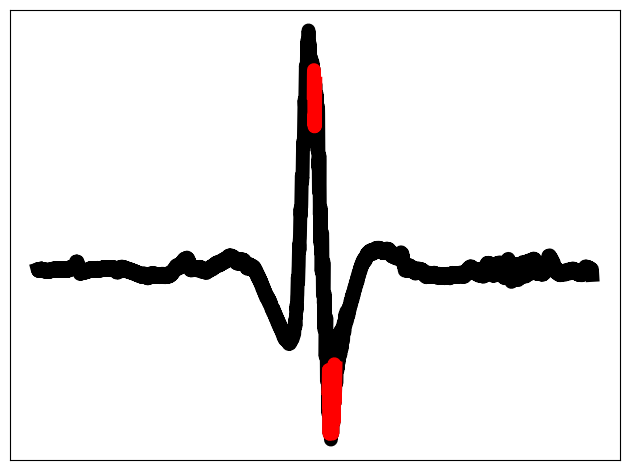

In [602]:
from captum.attr import IntegratedGradients
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LinearSegmentedColormap
import numpy as np  # Ensure NumPy is imported

# Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get a sample from the combined dataset
xray_image, ecg_waveform, label = combined_dataset[662]

# Move the input tensors to the device
xray_image = xray_image.unsqueeze(0).to(device)
ecg_waveform_1 = ecg_waveform
ecg_waveform = ecg_waveform.unsqueeze(0).to(device)


# Preprocess and forward the sample through the MultimodalClassifier
model.eval()  # Set the model to evaluation mode

# Assuming the model and data are on the same device, if not, move them to the same device (e.g., model.to(device))
with torch.no_grad():
    logits = model(xray_image, ecg_waveform)

# Get the predicted label
_, predicted_label = torch.max(logits, 1)

# Print actual and predicted labels
actual_label = label  # Assuming `label` is a tensor. Adjust if your actual label format is different.
predicted_label = predicted_label.item()  # Convert tensor to integer for easier comparison/printing

print(f"Actual Label: {actual_label}")
print(f"Predicted Label: {predicted_label}")


# Step 1: Smooth the ECG signal
# Convert the 2D ECG signal array into a 1D array
ecg_waveform_1d = np.ravel(ecg_waveform_1)

# Now, use the `ecg_clean` function with the 1D array
ecg_smoothed = nk.ecg_clean(ecg_waveform_1d, sampling_rate=500)  # Adjust the sampling rate as per your data

# Initialize Integrated Gradients for the model
integrated_gradients = IntegratedGradients(model)

# Compute attributions for both X-ray and ECG inputs
# Note: We need to enable gradients by setting requires_grad to True for both inputs
# Convert ECG smoothed signal back to PyTorch tensor and then move it to the specified device
ecg_smoothed = torch.tensor(ecg_smoothed.copy(), dtype=torch.float32).to(device)


xray_image.requires_grad_(True)
ecg_smoothed.requires_grad_(True)

# Calculate attributions for X-ray and ECG together
attributions, _ = integrated_gradients.attribute(inputs=(xray_image, ecg_waveform),
                                                 target=predicted_label,
                                                 return_convergence_delta=True)

# Separate the attributions for the X-ray and ECG
attributions_xray = attributions[0]
attributions_ecg = attributions[1]

# Convert ECG attributions to numpy for visualization
attributions_ecg_np = attributions_ecg.cpu().detach().numpy().squeeze()

# Normalize the ECG attributions to get importance scores between 0 and 1 for the colormap
norm_attributions_ecg = (attributions_ecg_np - attributions_ecg_np.min()) / (attributions_ecg_np.max() - attributions_ecg_np.min())

# Visualize important regions for ECG
# (X-ray visualization would require a separate approach, not covered here)
threshold = 0.80
important_indices_ecg = np.where(norm_attributions_ecg >= threshold)
ecg_waveform_np = ecg_smoothed.cpu().detach().numpy().squeeze()

# Assuming attributions_np and ecg_waveform_np are already calculated

# Define the segment range you are interested in
start_index = 22000
end_index = 27000

# Extract the segment of interest from the ECG waveform and attributions
segment_ecg_waveform = ecg_waveform_np[start_index:end_index]
segment_attributions = norm_attributions_ecg[start_index:end_index]

# For plotting, we will also need the indices relative to the segment
segment_indices = np.arange(start_index, end_index)


# Define the threshold to identify important points
threshold = 0.70  # Adjust the threshold as necessary

# Calculate the important indices based on the threshold within the segment
important_indices_segment = np.where(segment_attributions >= threshold)[0]

# Convert logits to probabilities
probabilities = torch.softmax(logits, dim=1)
predicted_probability = probabilities[0, predicted_label].item()  # Get the probability of the predicted class


fig, ax = plt.subplots()

# Set the background color of the plot to white
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Increase linewidth for better visualization
waveform_linewidth = 10  # Adjust the ECG waveform line thickness
important_linewidth = 10  # Adjust the important regions line thickness

# Plot the entire segment of the ECG waveform in a base color (e.g., green) with increased linewidth
ax.plot(segment_indices, segment_ecg_waveform, label='ECG Waveform', color='black', alpha=1, linewidth=waveform_linewidth)
stretch_window =7

# Plot the stretched important segment in red with increased linewidth
for important_index in important_indices_segment:
    stretch_start = max(0, important_index - stretch_window)
    stretch_end = min(len(segment_ecg_waveform), important_index + stretch_window + 1)
    ax.plot(segment_indices[stretch_start:stretch_end], 
            segment_ecg_waveform[stretch_start:stretch_end], 
            color='red', linewidth=important_linewidth, zorder=3)

# Remove x-ticks and y-ticks
ax.set_xticks([])  # Remove x-ticks
ax.set_yticks([])  # Remove y-ticks

ax.set_xlabel('')
ax.set_ylabel('')

plt.tight_layout()
plt.show()


Actual Label: 0
Predicted Label: 0


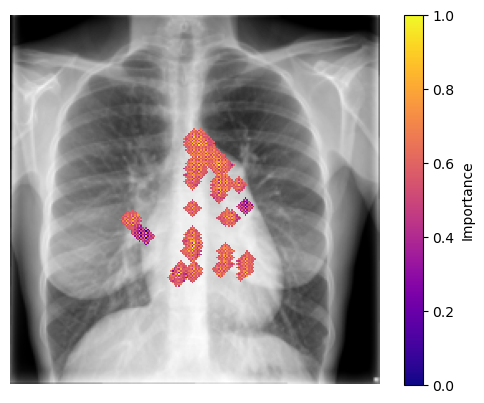

In [577]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import binary_dilation
from captum.attr import IntegratedGradients

# Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load a sample
xray_image, ecg_waveform, label = combined_dataset[10]  # Example index

# Move the input tensors to the device
xray_image = xray_image.unsqueeze(0).to(device)
ecg_waveform = ecg_waveform.unsqueeze(0).to(device)

# Process the sample through your model
model.eval()
with torch.no_grad():
    logits = model(xray_image, ecg_waveform)
_, predicted_label = torch.max(logits, 1)


# Print actual and predicted labels
actual_label = label  # Assuming `label` is a tensor. Adjust if your actual label format is different.
predicted_label = predicted_label.item()  # Convert tensor to integer for easier comparison/printing

print(f"Actual Label: {actual_label}")
print(f"Predicted Label: {predicted_label}")

# Initialize and compute Integrated Gradients
integrated_gradients = IntegratedGradients(model)
xray_image.requires_grad_(True)
ecg_waveform.requires_grad_(True)
attributions, _ = integrated_gradients.attribute(inputs=(xray_image, ecg_waveform),
                                                 target=predicted_label,
                                                 return_convergence_delta=True)
attributions_xray = attributions[0]

# Normalize attributions
attributions_xray_np = attributions_xray.cpu().detach().numpy().squeeze()
norm_attributions_xray = (attributions_xray_np - np.min(attributions_xray_np)) / \
                         (np.max(attributions_xray_np) - np.min(attributions_xray_np))
threshold = np.percentile(norm_attributions_xray, 99)
binary_mask = norm_attributions_xray >= threshold
dilated_mask = binary_dilation(binary_mask, iterations=5)
# Original X-ray image for visualization
xray_image_np = xray_image.cpu().detach().numpy().squeeze()

# Focusing on specific parts (e.g., a circle in the center)
height, width = norm_attributions_xray.shape

# Create a grid of coordinates
y, x = np.ogrid[:height, :width]

# Define the center and radius of the circle
center_y, center_x = height // 2, width // 2  # Center of the circle
radius = min(height, width) // 4  # Radius of the circle

# Compute mask for the circular region of interest
distance_from_center = np.sqrt((x - center_x)**2 + (y - center_y)**2)
circular_mask = distance_from_center <= radius

# Apply circular mask to the dilated mask
focused_mask = np.logical_and(dilated_mask, circular_mask)
focused_attributions_xray = np.where(focused_mask, norm_attributions_xray, np.nan)

# Assuming focused_attributions_xray is computed as before

# Normalize focused_attributions_xray from 0 to 1
min_val = np.nanmin(focused_attributions_xray)
max_val = np.nanmax(focused_attributions_xray)
# Avoid division by zero in case all values are the same
if max_val - min_val > 0:
    normalized_focused_attributions = (focused_attributions_xray - min_val) / (max_val - min_val)
else:
    normalized_focused_attributions = np.zeros_like(focused_attributions_xray)

# Visualization with normalized attributions
fig, ax = plt.subplots()
fig.patch.set_facecolor('white')
ax.set_facecolor('white')
ax.imshow(xray_image_np, cmap='gray', alpha=1)  # Original X-ray image
heatmap = ax.imshow(normalized_focused_attributions, cmap='plasma', alpha=1, interpolation='nearest')
cbar = plt.colorbar(heatmap, ax=ax)
cbar.set_label('Importance')
ax.axis('off')
plt.show()




Actual Label: 1
Predicted Label: 1


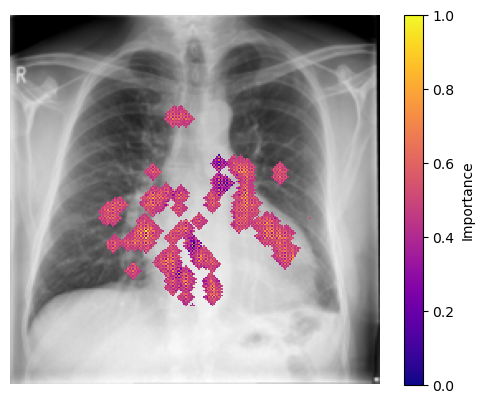

In [575]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import binary_dilation
from captum.attr import IntegratedGradients

# Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load a sample
xray_image, ecg_waveform, label = combined_dataset[675]  # Example index

# Move the input tensors to the device
xray_image = xray_image.unsqueeze(0).to(device)
ecg_waveform = ecg_waveform.unsqueeze(0).to(device)

# Process the sample through your model
model.eval()
with torch.no_grad():
    logits = model(xray_image, ecg_waveform)
_, predicted_label = torch.max(logits, 1)


# Print actual and predicted labels
actual_label = label  # Assuming `label` is a tensor. Adjust if your actual label format is different.
predicted_label = predicted_label.item()  # Convert tensor to integer for easier comparison/printing

print(f"Actual Label: {actual_label}")
print(f"Predicted Label: {predicted_label}")

# Initialize and compute Integrated Gradients
integrated_gradients = IntegratedGradients(model)
xray_image.requires_grad_(True)
ecg_waveform.requires_grad_(True)
attributions, _ = integrated_gradients.attribute(inputs=(xray_image, ecg_waveform),
                                                 target=predicted_label,
                                                 return_convergence_delta=True)
attributions_xray = attributions[0]

# Normalize attributions
attributions_xray_np = attributions_xray.cpu().detach().numpy().squeeze()
norm_attributions_xray = (attributions_xray_np - np.min(attributions_xray_np)) / \
                         (np.max(attributions_xray_np) - np.min(attributions_xray_np))
threshold = np.percentile(norm_attributions_xray, 98)
binary_mask = norm_attributions_xray >= threshold
dilated_mask = binary_dilation(binary_mask, iterations=5)
# Original X-ray image for visualization
xray_image_np = xray_image.cpu().detach().numpy().squeeze()

# Focusing on specific parts (e.g., a circle in the center)
height, width = norm_attributions_xray.shape

# Create a grid of coordinates
y, x = np.ogrid[:height, :width]

# Define the center and radius of the circle
center_y, center_x = height // 2, width // 1.9  # Center of the circle
radius = min(height, width) // 3.4  # Radius of the circle

# Compute mask for the circular region of interest
distance_from_center = np.sqrt((x - center_x)**2 + (y - center_y)**2)
circular_mask = distance_from_center <= radius

# Apply circular mask to the dilated mask
focused_mask = np.logical_and(dilated_mask, circular_mask)
focused_attributions_xray = np.where(focused_mask, norm_attributions_xray, np.nan)

# Assuming focused_attributions_xray is computed as before


# Normalize focused_attributions_xray from 0 to 1
min_val = np.nanmin(focused_attributions_xray)
max_val = np.nanmax(focused_attributions_xray)
# Avoid division by zero in case all values are the same
if max_val - min_val > 0:
    normalized_focused_attributions = (focused_attributions_xray - min_val) / (max_val - min_val)
else:
    normalized_focused_attributions = np.zeros_like(focused_attributions_xray)

# Visualization with normalized attributions
fig, ax = plt.subplots()
fig.patch.set_facecolor('white')
ax.set_facecolor('white')
ax.imshow(xray_image_np, cmap='gray', alpha=1)  # Original X-ray image
heatmap = ax.imshow(normalized_focused_attributions, cmap='plasma', alpha=1, interpolation='nearest')
cbar = plt.colorbar(heatmap, ax=ax)
cbar.set_label('Importance')
ax.axis('off')
plt.show()




Fine-tuning on Aspire Dataset (Xray)

In [5]:
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from PIL import Image
import os
import pydicom
import torch
from torch.utils.data import Dataset
import numpy as np

class XRayDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []

        # Loop through each label directory
        for label in [0, 1]:
            label_dir = os.path.join(root_dir, f'processed_label_{label}')
            for folder_name in os.listdir(label_dir):
                folder_path = os.path.join(label_dir, folder_name)
                image_name = os.listdir(folder_path)[0]  # Assuming only one image per folder
                if image_name.endswith('.jpg'):
                    self.images.append(os.path.join(folder_path, image_name))
                    self.labels.append(label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = Image.open(image_path)
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label
    
    def get_labels(self):
        return self.labels
    
 
# Initialize your dataset
xray_dataset = XRayDataset(root_dir='D:/Aspire_xray/xray', transform=transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.ToTensor(),
]))

labels = combined_dataset.get_labels()

In [6]:
import torch
import torch.nn as nn

class ImageClassifier(nn.Module):
    def __init__(self, pretrained_mvae, num_classes):
        super(ImageClassifier, self).__init__()
        self.image_encoder = pretrained_mvae.image_encoder
        
        # Assuming the image encoder outputs latent representations of a specific size (n_latents)
        image_feature_dim = pretrained_mvae.n_latents  # Assuming this is the dimensionality of the encoded image features
        
        # Freeze the encoder weights
        for param in self.image_encoder.parameters():
            param.requires_grad = False

        self.classifier = nn.Sequential(
            nn.Linear(image_feature_dim, 128),  # Connect the encoded image feature dimension to the first layer of the classifier
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes),
        )

    def forward(self, xray):
        mu_xray, _ = self.image_encoder(xray)  # Assuming the encoder returns a mean (mu) and a log variance (not used here)
        logits = self.classifier(mu_xray)  # Pass the encoded image features through the classifier
        return logits

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def train_classifier(model, train_loader, criterion, optimizer, epochs=50):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for xray, labels in train_loader:  # Adjusted to only use xray and labels
            xray, labels = xray.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(xray)  # Adjusted to only pass xray
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item() * labels.size(0)
        
        avg_loss = total_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')

def evaluate_model(model, data_loader):
    model.eval()
    all_labels = []
    all_probs = []
    all_preds = []
    
    with torch.no_grad():
        for xray, labels in data_loader:  # Adjusted to only use xray and labels
            xray, labels = xray.to(device), labels.to(device)
            logits = model(xray)  # Adjusted to only pass xray
            probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1)
            
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())  # Assuming binary classification
            all_preds.extend(preds.cpu().numpy())
    
    auc_score = roc_auc_score(all_labels, all_probs)
    accuracy = accuracy_score(all_labels, all_preds)
    
    return accuracy, auc_score


Using device: cuda


In [8]:
import torch
import random
from sklearn.model_selection import StratifiedKFold
import numpy as np
from torch.utils.data import DataLoader, Subset
import torch.optim as optim
import torch.nn as nn

from sklearn.metrics import accuracy_score, roc_auc_score

def set_seed(seed_value):
    """Set seed for reproducibility."""
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set a seed value
seed = 42
set_seed(seed)

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
fold_results = []

for fold, (train_ids, test_ids) in enumerate(skf.split(np.zeros(len(labels)), labels)):
    
    train_subset = Subset(xray_dataset, train_ids)  # Ensure this only provides X-ray data
    test_subset = Subset(xray_dataset, test_ids)  # Ensure this only provides X-ray data
    
    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)
    
    # Assuming the ImageClassifier is defined to work with the image encoder from the MVAE
    pretrained_mvae = CardioVAE(image_input_channels=1, ecg_input_dim=60000, latent_dim=256).to(device)
    pretrained_mvae.load_state_dict(torch.load('pretrained_models/cardiovae.pth', map_location=device))
    
    # Initialize the classifier for this fold
    model = ImageClassifier(pretrained_mvae=pretrained_mvae, num_classes=2).to(device)
    
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
    criterion = nn.CrossEntropyLoss()
    
    # Train the model (ensure train_classifier is modified for X-ray only)
    train_classifier(model, train_loader, criterion, optimizer, epochs=50)
    
    # Evaluate the model on the test set (ensure evaluate_model is modified for X-ray only)
    accuracy, auc_score = evaluate_model(model, test_loader)
    fold_results.append((accuracy, auc_score))
    
# Calculate and print the mean and STD for each metric across folds
accuracies, aucs = zip(*fold_results)
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)

print(f'Mean Accuracy: {mean_accuracy:.3f}, STD: {std_accuracy:.3f}')
print(f'Mean AUC: {mean_auc:.3f}, STD: {std_auc:.3f}')


Mean Accuracy: 0.709, STD: 0.04 
Mean AUC: 0.681, STD: 0.05


Fine-tuning on Aspire Dataset (ECG)


In [12]:
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from PIL import Image
import os
import pydicom
import torch
from torch.utils.data import Dataset
import numpy as np

def process_dicom(file_path, sampling_rate=500):
    desired_length = 10 * sampling_rate  # 10 seconds of data
    try:
        dicom_data = pydicom.dcmread(file_path)
        if "WaveformSequence" in dicom_data:
            rhythm_waveform = dicom_data.WaveformSequence[1]
            wave_data = rhythm_waveform.get("WaveformData")
            num_channels = rhythm_waveform.NumberOfWaveformChannels
            wave_array = np.frombuffer(wave_data, dtype=np.int16)
            num_samples_per_channel = wave_array.size // num_channels
            
            if wave_array.size % num_channels == 0:
                wave_array = wave_array.reshape(num_samples_per_channel, num_channels)
                

                # Trim or Pad the array to 10 seconds
                if wave_array.shape[0] > desired_length:
                    wave_array = wave_array[:desired_length, :]
                elif wave_array.shape[0] < desired_length:
                    padding = np.zeros((desired_length - wave_array.shape[0], num_channels), dtype=wave_array.dtype)
                    wave_array = np.vstack((wave_array, padding))
                
                # Normalize the array
                wave_array = (wave_array - np.mean(wave_array, axis=0)) / np.std(wave_array, axis=0)

                return wave_array
            else:
                print(f"Unexpected data size in {file_path}. Skipping file.")
                return None
        else:
            print(f"No Waveform data found in {file_path}. Skipping file.")
            return None
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return None


class ECGDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.ecg_data = []
        self.labels = []

        # Loop through each label directory
        for label in [0, 1]:
            label_dir = os.path.join(root_dir, f'processed_label_{label}')
            for folder_name in os.listdir(label_dir):
                folder_path = os.path.join(label_dir, folder_name)
                for file_name in os.listdir(folder_path):
                    if file_name.endswith('.dcm'):
                        file_path = os.path.join(folder_path, file_name)
                        ecg_waveform = process_dicom(file_path)
                        if ecg_waveform is not None:
                            self.ecg_data.append(ecg_waveform)
                            self.labels.append(label)

    def __len__(self):
        return len(self.ecg_data)

    def __getitem__(self, idx):
        ecg_waveform = self.ecg_data[idx]
        label = self.labels[idx]
        # Reshape waveform to [1, signal_length]
        ecg_waveform = ecg_waveform.reshape(1, -1)  
        return torch.tensor(ecg_waveform, dtype=torch.float32), label

# Usage example
ecg_dataset = ECGDataset(root_dir='D:/Aspire_ecg/ecg')

In [13]:
import torch
import torch.nn as nn

class ECGClassifier(nn.Module):
    def __init__(self, pretrained_mvae, num_classes):
        super(ECGClassifier, self).__init__()
        self.ecg_encoder = pretrained_mvae.ecg_encoder

        # Assuming the ECG encoder outputs latent representations of a specific size (n_latents)
        ecg_feature_dim = pretrained_mvae.n_latents  # Assuming this is the dimensionality of the encoded ECG features

        # Freeze the encoder weights
        for param in self.ecg_encoder.parameters():
            param.requires_grad = False

        self.classifier = nn.Sequential(
            nn.Linear(ecg_feature_dim, 128),  # Connect the encoded ECG feature dimension to the first layer of the classifier
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes),
        )

    def forward(self, ecg):
        mu_ecg, _ = self.ecg_encoder(ecg)  # Assuming the encoder returns a mean (mu) of the encoded features
        logits = self.classifier(mu_ecg)  # Pass the encoded ECG features through the classifier
        return logits


In [14]:
def train_classifier(model, train_loader, criterion, optimizer, epochs=50):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for ecg, labels in train_loader:  # Only use ECG and labels
            ecg, labels = ecg.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(ecg)  # Pass only ECG data
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item() * labels.size(0)
        
        avg_loss = total_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')

def evaluate_model(model, data_loader):
    model.eval()
    all_labels = []
    all_probs = []
    all_preds = []
    
    with torch.no_grad():
        for ecg, labels in data_loader:  # Only use ECG and labels
            ecg, labels = ecg.to(device), labels.to(device)
            logits = model(ecg)  # Pass only ECG data
            probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1)
            
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())  # Assuming binary classification
            all_preds.extend(preds.cpu().numpy())
    
    auc_score = roc_auc_score(all_labels, all_probs)
    accuracy = accuracy_score(all_labels, all_preds)
    
    return accuracy, auc_score


In [16]:

import torch
import random
from sklearn.model_selection import StratifiedKFold
import numpy as np
from torch.utils.data import DataLoader, Subset
import torch.optim as optim
import torch.nn as nn

from sklearn.metrics import accuracy_score, roc_auc_score


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def set_seed(seed_value):
    """Set seed for reproducibility."""
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set a seed value
seed = 42
set_seed(seed)

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
fold_results = []

for fold, (train_ids, test_ids) in enumerate(skf.split(np.zeros(len(labels)), labels)):
    
    # Ensure train_subset and test_subset only provide ECG data
    train_subset = Subset(ecg_dataset, train_ids)  
    test_subset = Subset(ecg_dataset, test_ids)  
    
    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)
    
    # Initialize the ECG-focused classifier
    pretrained_mvae = CardioVAE(image_input_channels=1, ecg_input_dim=60000, latent_dim=256).to(device)
    pretrained_mvae.load_state_dict(torch.load('pretrained_models/cardiovae.pth', map_location=device))
    
    # Adjust this to use an ECG-focused classifier instead of ImageClassifier
    model = ECGClassifier(pretrained_mvae=pretrained_mvae, num_classes=2).to(device)
    
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
    criterion = nn.CrossEntropyLoss()
    
    # Train the model using only ECG data
    train_classifier(model, train_loader, criterion, optimizer, epochs=50)
    
    # Evaluate the model on the test set using only ECG data
    accuracy, auc_score = evaluate_model(model, test_loader)
    fold_results.append((accuracy, auc_score))
    
# Calculate and print the mean and STD for each metric across folds
accuracies, aucs = zip(*fold_results)
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)

print(f'Mean Accuracy: {mean_accuracy:.4f}, STD: {std_accuracy:.4f}')
print(f'Mean AUC: {mean_auc:.4f}, STD: {std_auc:.4f}')


Mean Accuracy: 0.727, STD: 0.04
Mean AUC: 0.744, STD: 0.05
